# Which sentiment is reflected by lyrics of english song during political/economical crisis, in countries where that language is primary ? 

## Packages import

In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

## Dataset import

In [ ]:
# Approximately 3 to 6 minutes to run
USE_COLS = [
    "lyrics",
    "year",
    "language_cld3",
    "language_ft",
    "tag",
    "artist",
    "title",
    "views"
]

chunks = []
CHUNK_SIZE = 50_000  

for chunk in pd.read_csv(
    "song_lyrics_filtered.csv",
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=True,
    engine="python"  
):
    # filtrage immédiat
    chunk = chunk[
        (chunk["language_cld3"] == "en") &
        (chunk["language_ft"] == "en") &
        (chunk["tag"] == "pop")
    ]
    
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

print(df.shape)
df.head()

(1393559, 8)


,title,tag,artist,year,views,lyrics,language_cld3,language_ft
0,Wordy Rappinghood,pop,Tom Tom Club,1981,26499,[Chorus]\nWhat are words worth?\nWhat are word...,en,en
1,Horchata,pop,Vampire Weekend,2009,102550,"[Verse 1]\nIn December, drinking horchata\nI'd...",en,en
2,Heartless,pop,Kanye West,2008,1175109,"[Chorus]\nIn the night, I hear 'em talk\nThe c...",en,en
3,Flashing Lights,pop,Kanye West,2007,1078113,[Intro: Connie Mitchell]\nFlashing lights (Lig...,en,en
4,Baby,pop,Justin Bieber,2010,2232442,[Produced by The-Dream and Tricky Stewart]\n\n...,en,en


In [3]:
# Suppression des colonnes inutiles
df = df.drop(["language_cld3", "language_ft", "tag"], axis=1)

In [4]:
# Enregistrement du df en parquet
df.to_parquet(
    "data/pop_lyrics.parquet",
    index=False
)

In [ ]:
# Chargement du df filtré
df = pd.read_parquet("data/pop_lyrics.parquet")
df.head()

,title,artist,year,views,lyrics
0,Killa Cam,Cam'ron,2004,173166,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,1996,468624,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,2003,4743,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,2004,144404,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,2005,78271,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


## Global descriptive statistics

In [13]:
df.info()
# no missing values 

<class 'pandas.DataFrame'>
Index: 1390653 entries, 0 to 1393558
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   title   1390630 non-null  str  
 1   artist  1390653 non-null  str  
 2   year    1390653 non-null  int64
 3   views   1390653 non-null  int64
 4   lyrics  1390653 non-null  str  
dtypes: int64(2), str(3)
memory usage: 1.6 GB


In [6]:
# Dupes check in df
df[df.duplicated(subset=["title", "artist"], keep=False)] \
  .sort_values(["artist", "title"])

,title,artist,year,views,lyrics
1175764,Celebrate Me Home,CAIN,2020,666,[Verse 1]\nHome for the holidays\nI believe I'...
1255799,Celebrate Me Home,CAIN,2020,32,[Verse 1]\nHome for the holidays\nI believe I'...
989544,HOT,kenzie,2019,32727,[Verse 1]\nShould've listened to my friends\nT...
990182,HOT,kenzie,2019,6911,[Intro]\nWatch out\nWatch out\n\n[Verse 1]\nSh...


In [7]:
# Removing dupes
df = df.drop_duplicates(subset=["title", "artist"], keep="first")
df.shape

(1393557, 5)

In [ ]:
# Descriptive statistics for numerics columns
df[["year", "views"]].describe()
# Incoherence in values for year (min)

,year,views
count,1.390653e+06,1.390653e+06
mean,2.008798e+03,2.387391e+03
std,1.293257e+01,4.274120e+04
min,1.950000e+03,0.000000e+00
25%,2.003000e+03,3.100000e+01
50%,2.014000e+03,1.070000e+02
75%,2.018000e+03,3.980000e+02
max,2.023000e+03,1.456973e+07


In [14]:
songs_per_year = df["year"].value_counts().sort_index()
songs_per_year.head()

year
1950    210
1951    184
1952    197
1953    232
1954    304
Name: count, dtype: int64

In [10]:
# Filter to keep only years between 1950 and 2023
df = df[(df["year"] >= 1950) & (df["year"] <= 2023)]
df.shape

(1390653, 5)

In [16]:
print(songs_per_year)

year
1950       210
1951       184
1952       197
1953       232
1954       304
         ...  
2019     89177
2020    110099
2021    104796
2022     22709
2023       107
Name: count, Length: 74, dtype: int64


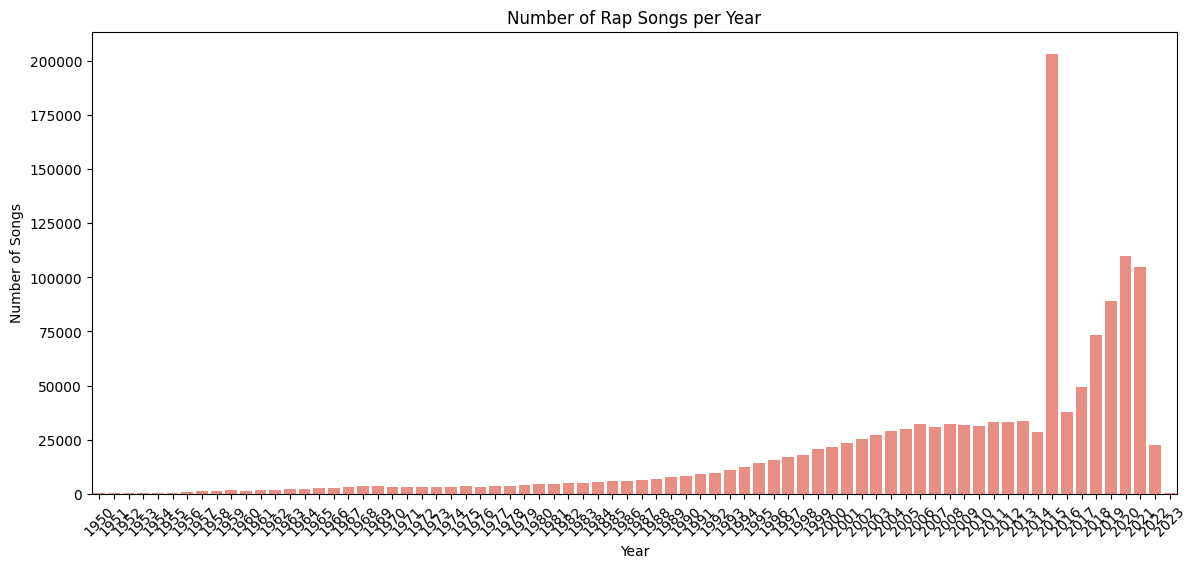

In [17]:
songs_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, color="salmon")
plt.title("Number of Rap Songs per Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Keeping rows only from the year 1980 to 2023
df = df[(df["year"] >= 1980) & (df["year"] <= 2023)]
df["year"].describe()

count    1.326010e+06
mean     2.010722e+03
std      9.669619e+00
min      1.980000e+03
25%      2.005000e+03
50%      2.015000e+03
75%      2.018000e+03
max      2.023000e+03
Name: year, dtype: float64

In [19]:
df["artist"].value_counts().head(10)
# Genius English Translations needs to be removed (the originals songs are not in English)

artist
Genius English Translations    8091
KIDZ BOP Kids                  1181
Madonna                         949
YOUNG DIAMOND                   833
Glee Cast                       706
Pet Shop Boys                   611
Erasure                         590
Depeche Mode                    569
Kylie Minogue                   548
Mariah Carey                    536
Name: count, dtype: int64

In [20]:
# Removing Genius translations
mask_artist = ~df["artist"].str.contains(
    "Genius|Translation|Translations",
    case=False,
    na=False
)

# Removing lyrics too small
#mask_length = df["clean_lyrics"].str.split().str.len() >= 50

# Filter
df = df[mask_artist 
        #& mask_length
        ]

# Check
df["artist"].value_counts().head(10)

artist
KIDZ BOP Kids       1181
Madonna              949
YOUNG DIAMOND        833
Glee Cast            706
Pet Shop Boys        611
Erasure              590
Depeche Mode         569
Kylie Minogue        548
Mariah Carey         536
Hillsong Worship     531
Name: count, dtype: int64

In [21]:
# Quick check of the title and count coherence
df[df["artist"] == "Madonna"]["title"].value_counts().head(20)

title
4 Minutes                           1
Beat Goes On                        1
Like a Virgin / Hollywood Medley    1
Give Me All Your Luvin              1
I Dont Give A                       1
Girl Gone Wild                      1
Love Spent                          1
Im Addicted                         1
Die Another Day                     1
Like a Virgin                       1
Beautiful Stranger                  1
Dress You Up                        1
Vogue                               1
Superstar                           1
Express Yourself                    1
Like a Prayer                       1
Gang Bang                           1
Falling Free                        1
Music                               1
Material Girl                       1
Name: count, dtype: int64

In [22]:
# Shape
df.shape

(1317331, 5)

## Lyrics pre processing

In [ ]:
# Approximately 3 to 4 minutes to run
nltk.download("stopwords")
STOPWORDS = set(stopwords.words("english"))

def clean_lyrics(text):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()
    tokens = [
        w for w in text.split()
        if w not in STOPWORDS and len(w) > 2
    ]
    return " ".join(tokens)

df["clean_lyrics"] = df["lyrics"].astype(str).apply(clean_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# View of clean lyrics
print(df["clean_lyrics"].head())
print(df["clean_lyrics"].loc[1])

0    words worth words worth words words papers wor...
1    december drinking horchata look psychotic bala...
2    night hear talk coldest story ever told somewh...
3    flashing lights lights lights flashing lights ...
4    woah woah woah know love know care shout whene...
Name: clean_lyrics, dtype: str
december drinking horchata look psychotic balaclava winter cold much handle pincher crabs pinch sandals december drinking horchata look glasses aranciata lips teeth ask day went boots fists pound pavement comes feeling thought forgotten chairs sit sidewalks walk remember drinking horchata still enjoy foot masada winter cold much handle pincher crabs pinch sandals comes feeling thought forgotten chairs sit sidewalks walk lost looking back fought december drinking horchata look psychotic balaclava winter cold much handle pincher crabs pinch sandals years hearts start harden palms firs grew garden falling nearing rosebeds roots shooting tool shed lips teeth asked day went shouting cracks 

In [25]:
df.to_parquet(
    "data/pop_lyrics_nlp_clean.parquet",
    index=False
)

In [2]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

## Sentiment Analysis - Vader

### Top musics (by views of the page)

In [ ]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 1000  
# years were there are more than 1000 pop songs :  
START_YEAR = 1980
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_top = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, False])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_top))
df_top["year"].value_counts().sort_index()

Total songs selected: 43000


year
1980    1000
1981    1000
1982    1000
1983    1000
1984    1000
1985    1000
1986    1000
1987    1000
1988    1000
1989    1000
1990    1000
1991    1000
1992    1000
1993    1000
1994    1000
1995    1000
1996    1000
1997    1000
1998    1000
1999    1000
2000    1000
2001    1000
2002    1000
2003    1000
2004    1000
2005    1000
2006    1000
2007    1000
2008    1000
2009    1000
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
Name: count, dtype: int64

In [ ]:
# Approximately 7 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_top["sentiment"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_top["sentiment_neg"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_top["sentiment_pos"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_top["sentiment_neu"] = df_top["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [6]:
df_top.to_parquet(
    "data/pop_lyrics_vader_top.parquet",
    index=False
)

### Less popular musics (by views of the page)

In [28]:
# NEED TO RESTART THE KERNEL (for the memory)
raise RuntimeError(
    "IMPORTANT: Restart the kernel (Kernel → Restart), then Run the rest of the cells.\n"
    "This notebook uses large Arrow-backed DataFrames."
)

RuntimeError: IMPORTANT: Restart the kernel (Kernel → Restart), then Run the rest of the cells.
This notebook uses large Arrow-backed DataFrames.

In [ ]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from nrclex import NRCLex
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

In [ ]:
# Import of clean lyrics df
df = pd.read_parquet(
    "data/pop_lyrics_nlp_clean.parquet"
)

In [ ]:
# Approximately 1 to 2 minutes to run
MAX_PER_YEAR = 1000  
START_YEAR = 1980
END_YEAR = 2022

df_filtered = df.query(
    "year >= @START_YEAR and year <= @END_YEAR"
)

df_flop = (
    df_filtered
    .sort_values(["year", "views"], ascending=[True, True])
    .groupby("year", group_keys=False)
    .head(MAX_PER_YEAR)
)

print("Total songs selected:", len(df_flop))
df_flop["year"].value_counts().sort_index()

Total songs selected: 43000


year
1980    1000
1981    1000
1982    1000
1983    1000
1984    1000
1985    1000
1986    1000
1987    1000
1988    1000
1989    1000
1990    1000
1991    1000
1992    1000
1993    1000
1994    1000
1995    1000
1996    1000
1997    1000
1998    1000
1999    1000
2000    1000
2001    1000
2002    1000
2003    1000
2004    1000
2005    1000
2006    1000
2007    1000
2008    1000
2009    1000
2010    1000
2011    1000
2012    1000
2013    1000
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
Name: count, dtype: int64

In [ ]:
# Approximately 5 to 7 minutes to run
analyzer = SentimentIntensityAnalyzer()

df_flop["sentiment"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["compound"])
df_flop["sentiment_neg"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neg"])
df_flop["sentiment_pos"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["pos"])
df_flop["sentiment_neu"] = df_flop["clean_lyrics"].apply(lambda x: analyzer.polarity_scores(x[:1000])["neu"])

In [10]:
df_flop.to_parquet(
    "data/pop_lyrics_vader_flop.parquet",
    index=False
)

In [2]:
# Import of top and flop sentiment vader df
df_top = pd.read_parquet(
    "data/pop_lyrics_vader_top.parquet"
)

df_flop = pd.read_parquet(
    "data/pop_lyrics_vader_flop.parquet"
)

### Vader - Visualisation 

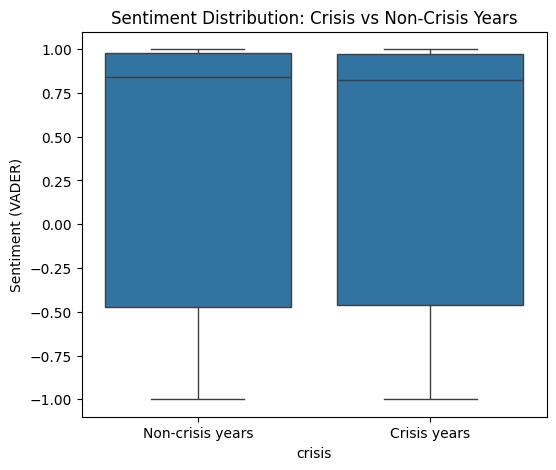

In [12]:
crisis_years = [
    1991,  # Gulf War
    2001,  # 9/11
    2008, 2009,  # Financial crisis
    2020, 2021  # COVID
]

df_flop["crisis"] = df_flop["year"].isin(crisis_years)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=df_flop,
    x="crisis",
    y="sentiment"
)

plt.xticks([0,1], ["Non-crisis years", "Crisis years"])
plt.title("Sentiment Distribution: Crisis vs Non-Crisis Years")
plt.ylabel("Sentiment (VADER)")
plt.show()


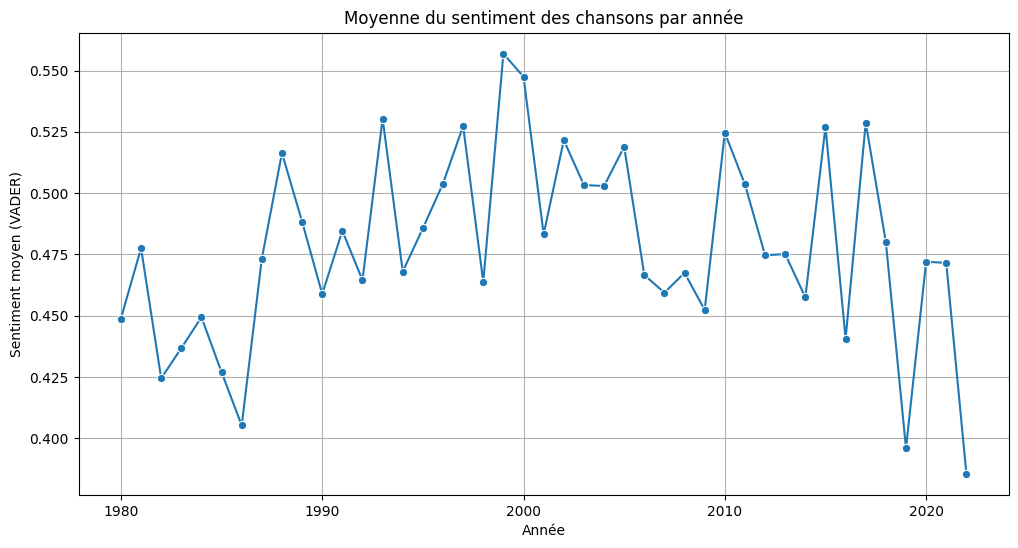

In [ ]:
sentiment_year = df_top.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=sentiment_year.index, y=sentiment_year.values, marker="o")
plt.title("Moyenne du sentiment des chansons par année")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.grid(True)
plt.show()

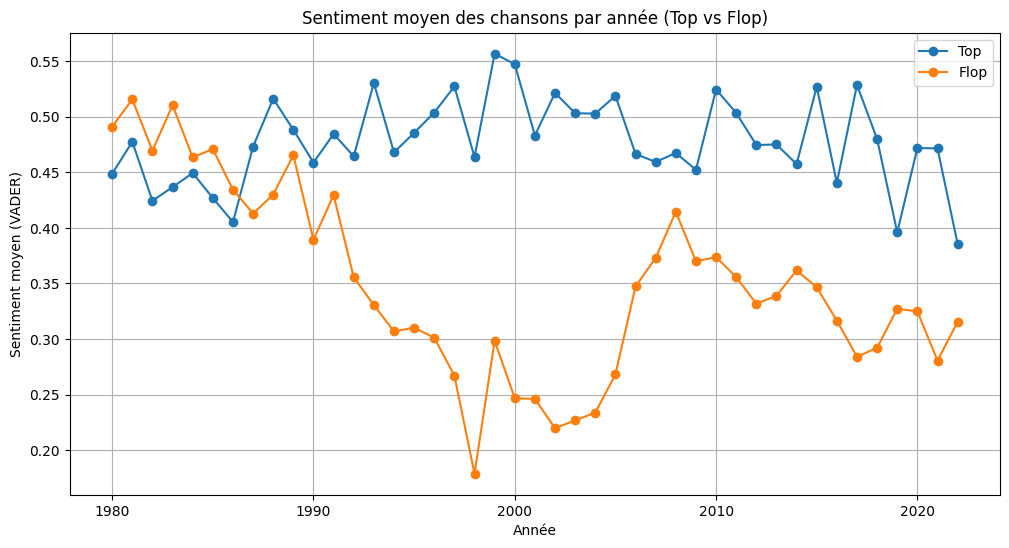

In [13]:
sentiment_top = df_top.groupby("year")["sentiment"].mean()
sentiment_flop = df_flop.groupby("year")["sentiment"].mean()

plt.figure(figsize=(12, 6))
plt.plot(sentiment_top.index, sentiment_top.values, marker="o", label="Top")
plt.plot(sentiment_flop.index, sentiment_flop.values, marker="o", label="Flop")

plt.title("Sentiment moyen des chansons par année (Top vs Flop)")
plt.xlabel("Année")
plt.ylabel("Sentiment moyen (VADER)")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Event years
us_event_years = {
    1980: "Election of Ronald Reagan (neoliberal shift)",
    1981: "AIDS crisis (public recognition)",
    1984: "Thatcher–Reagan era – economic deregulation",
    1989: "Fall of the Berlin Wall (end of the Cold War)",
    1991: "Gulf War",
    1992: "Los Angeles riots (Rodney King)",
    1994: "Crime Bill and mass incarceration (USA)",
    1997: "Election of Tony Blair (New Labour)",
    2001: "September 11 terrorist attacks",
    2003: "Iraq War",
    2005: "Hurricane Katrina",
    2008: "Global financial crisis / Election of Barack Obama",
    2011: "Occupy Wall Street movement",
    2013: "Beginning of the Black Lives Matter movement",
    2014: "Ferguson protests and police violence coverage",
    2016: "Brexit / Election of Donald Trump",
    2017: "#MeToo movement",
    2018: "Racial tensions and political polarization",
    2020: "COVID-19 pandemic / George Floyd and global BLM protests",
    2021: "January 6 Capitol riot",
    2022: "War in Ukraine / global inflation"
}

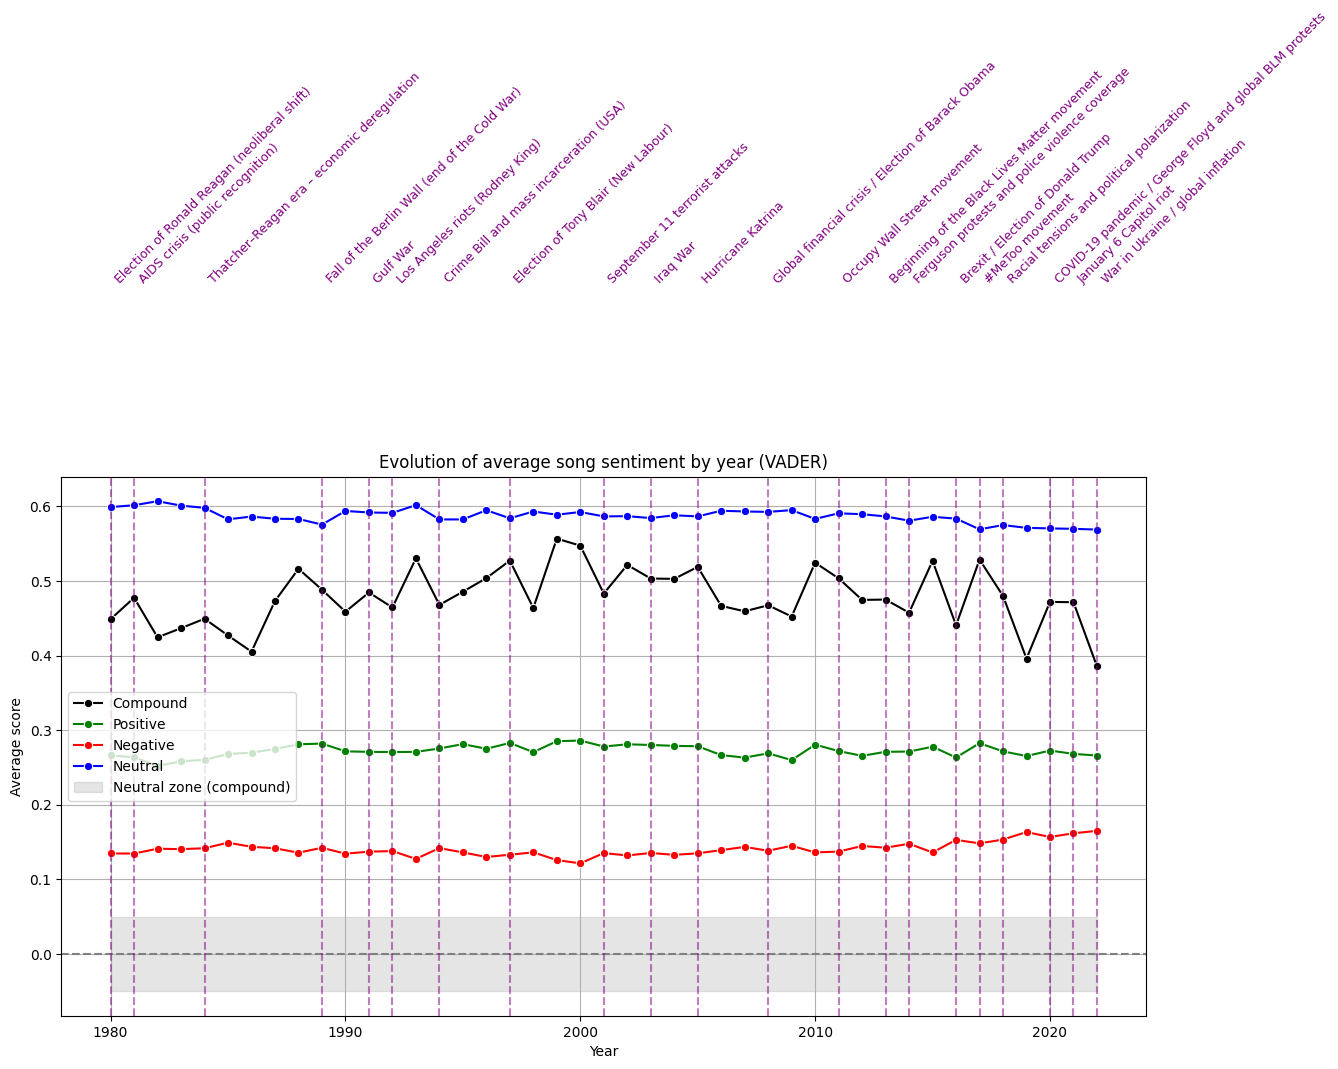

In [ ]:
# Scores mean/median per years for top songs
sentiment_by_year = df_top.groupby("year")[
    ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]
].mean()

plt.figure(figsize=(14,7))

sns.lineplot(
    x=sentiment_by_year.index,
    y=sentiment_by_year["sentiment"],
    marker="o",
    color="black",
    label="Compound"
)

sns.lineplot(
    x=sentiment_by_year.index,
    y=sentiment_by_year["sentiment_pos"],
    marker="o",
    color="green",
    label="Positive"
)

sns.lineplot(
    x=sentiment_by_year.index,
    y=sentiment_by_year["sentiment_neg"],
    marker="o",
    color="red",
    label="Negative"
)

sns.lineplot(
    x=sentiment_by_year.index,
    y=sentiment_by_year["sentiment_neu"],
    marker="o",
    color="blue",
    label="Neutral"
)

plt.axhline(0, color="gray", linestyle="--")
plt.fill_between(sentiment_by_year.index, -0.05, 0.05, color="gray", alpha=0.2, label="Neutral zone (compound)"
)

for year, event in us_event_years.items():
    if year in sentiment_by_year.index:
        plt.axvline(year, color="purple", linestyle="--", alpha=0.5)
        plt.text(year + 0.1, 0.9, event, rotation=45, fontsize=9, color="purple")

plt.title("Evolution of average song sentiment by year (VADER)")
plt.xlabel("Year")
plt.ylabel("Average score")
plt.legend()
plt.grid(True)
plt.show()

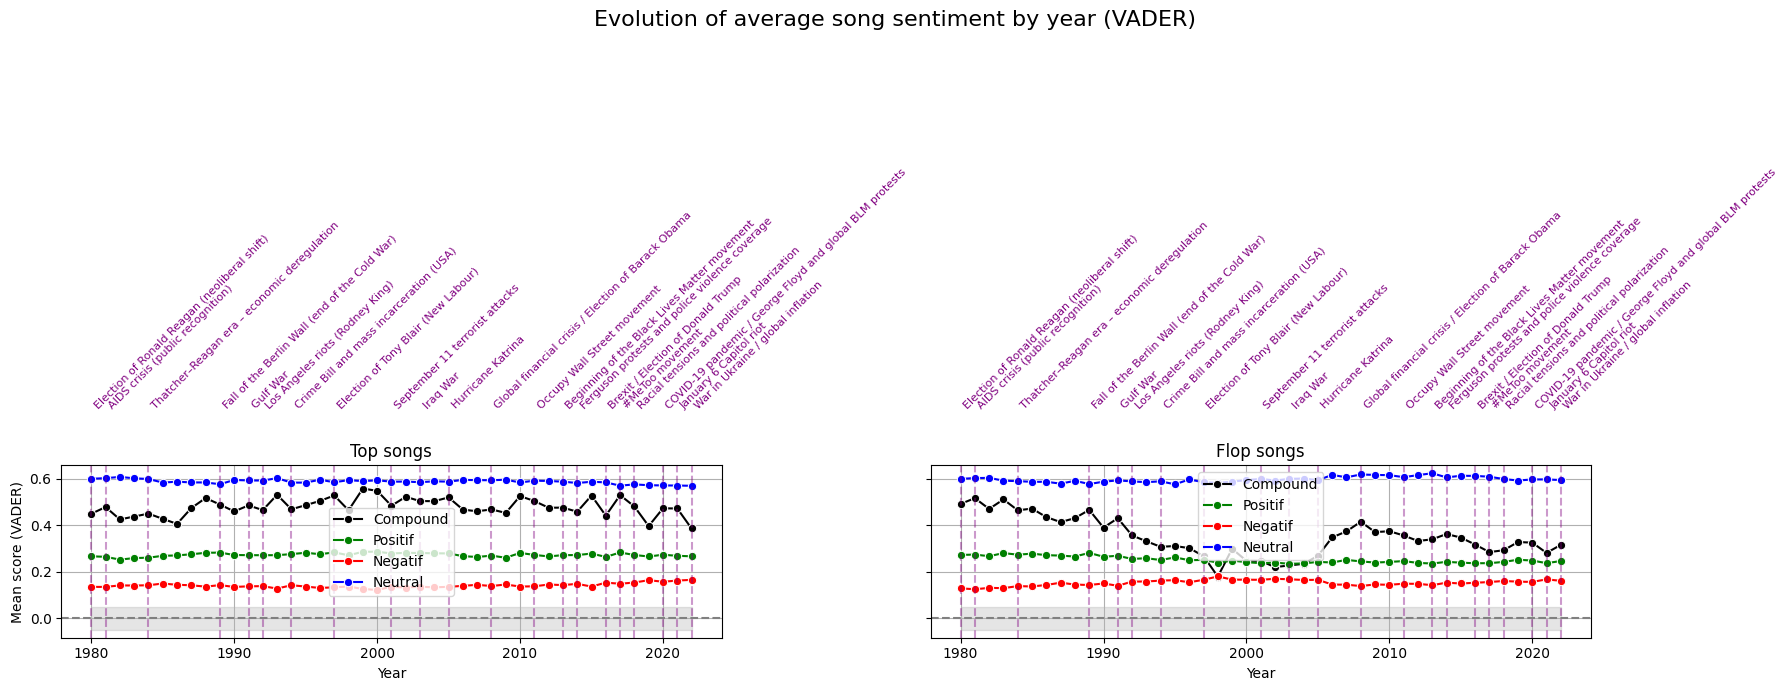

In [7]:
# Comparison between top and flop
cols = ["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]

sent_top = (
    df_top
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Top")
)

sent_flop = (
    df_flop
    .groupby("year")[cols]
    .mean()
    .reset_index()
    .assign(type="Flop")
)

sentiment_by_year = pd.concat([sent_top, sent_flop], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for ax, label in zip(axes, ["Top", "Flop"]):
    data = sentiment_by_year[sentiment_by_year["type"] == label]

    sns.lineplot(
        data=data,
        x="year",
        y="sentiment",
        marker="o",
        color="black",
        label="Compound",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_pos",
        marker="o",
        color="green",
        label="Positif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neg",
        marker="o",
        color="red",
        label="Negatif",
        ax=ax
    )
    sns.lineplot(
        data=data,
        x="year",
        y="sentiment_neu",
        marker="o",
        color="blue",
        label="Neutral",
        ax=ax
    )

    ax.axhline(0, color="gray", linestyle="--")
    ax.fill_between(
        data["year"].unique(),
        -0.05, 0.05,
        color="gray", alpha=0.2
    )

    for year, event in us_event_years.items():
        if year in data["year"].values:
            ax.axvline(year, color="purple", linestyle="--", alpha=0.4)
            ax.text(year + 0.1, 0.9, event, rotation=45,
                    fontsize=8, color="purple")

    ax.set_title(f"{label} songs")
    ax.set_xlabel("Year")
    ax.grid(True)

axes[0].set_ylabel("Mean score (VADER)")
fig.suptitle("Evolution of average song sentiment by year (VADER)", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Mean and median of Vader scores per year (for top songs here)
sentiment_stats = df_top.groupby("year")[["sentiment", "sentiment_pos", "sentiment_neg", "sentiment_neu"]].agg(
    ["mean", "median"]
)

print(sentiment_stats)

     sentiment          sentiment_pos         sentiment_neg          \
          mean   median          mean  median          mean  median   
year                                                                  
1980  0.448878  0.92100      0.266118  0.2405      0.134729  0.1090   
1981  0.477582  0.93200      0.263803  0.2460      0.134600  0.1070   
1982  0.424478  0.90970      0.251901  0.2320      0.141084  0.1180   
1983  0.436800  0.93215      0.258375  0.2350      0.140491  0.1100   
1984  0.449416  0.91425      0.260179  0.2390      0.141716  0.1150   
1985  0.426975  0.93820      0.268081  0.2480      0.149162  0.1240   
1986  0.405280  0.92670      0.269867  0.2460      0.143673  0.1220   
1987  0.473265  0.94420      0.274839  0.2540      0.141667  0.1180   
1988  0.516370  0.94425      0.281086  0.2670      0.135724  0.1110   
1989  0.488394  0.94575      0.282034  0.2620      0.142338  0.1150   
1990  0.458848  0.93745      0.271631  0.2520      0.134419  0.1135   
1991  

## Analysis emotional power - NRC

In [ ]:
raise RuntimeError(
    "IMPORTANT: Need to download the NRC-Emotion-Lexicon-Wordlevel-v0.92.txt from:\n"
    "https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm"
)

https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [9]:
# Charger le lexique
nrc = pd.read_csv(
    "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep="\t",
    names=["word", "emotion", "association"]
)

# On ne garde que les mots associés à une émotion
nrc = nrc[nrc["association"] == 1]

# Créer un dictionnaire {mot: [emotions]}
from collections import defaultdict

nrc_dict = defaultdict(list)
for _, row in nrc.iterrows():
    nrc_dict[row["word"]].append(row["emotion"])

In [10]:
def nrc_score(text, lexicon=nrc_dict):
    tokens = text.lower().split()  # on tokenise simplement par espace
    emotion_counts = Counter()
    
    for token in tokens:
        for emotion in lexicon.get(token, []):
            emotion_counts[emotion] += 1
    
    total = sum(emotion_counts.values())
    if total == 0:
        # Aucun mot associé trouvé, on retourne 0 pour chaque émotion
        return {e: 0 for e in [
            "anger","anticipation","disgust","fear","joy",
            "sadness","surprise","trust","positive","negative"
        ]}
    
    # Normaliser par le total
    return {k: v/total for k, v in emotion_counts.items()}


In [ ]:
# Top songs
# Limiter éventuellement à 1000 mots par texte pour accélérer
df_top["nrc_scores"] = df_top["clean_lyrics"].apply(lambda x: nrc_score(x[:1000]))

# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

# Exemple : voir les 5 premières lignes
df_top[["anger","joy","sadness","positive","negative"]].head()

,anger,joy,sadness,positive,negative
0,NaN,NaN,0.150000,0.200000,0.150000
1,0.027397,0.095890,0.027397,0.164384,0.095890
2,0.057143,0.028571,0.014286,0.042857,0.028571
3,0.034483,0.137931,0.103448,0.172414,0.172414
4,NaN,0.177215,0.063291,0.316456,0.037975


In [12]:
# Convertir en colonnes séparées
nrc_df = df_top["nrc_scores"].apply(pd.Series)
df_top = pd.concat([df_top, nrc_df], axis=1)

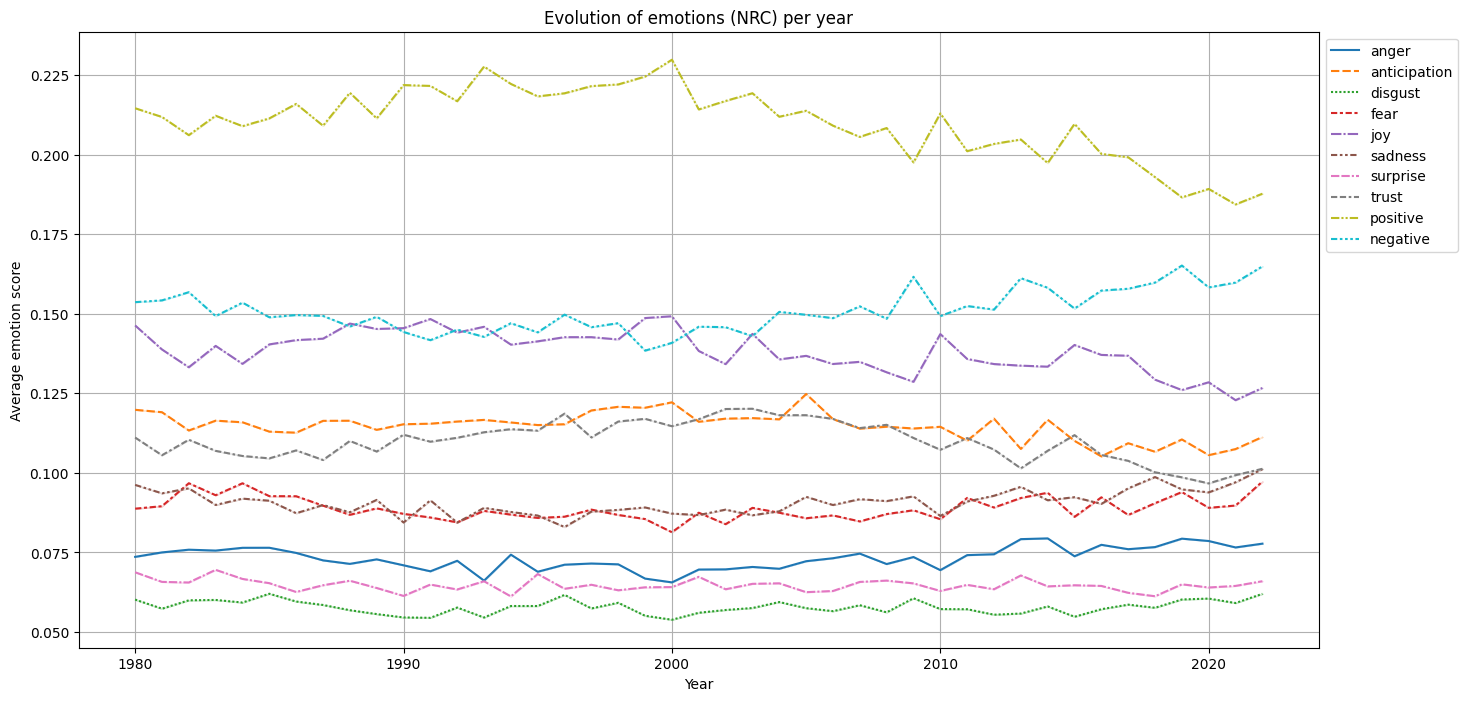

In [ ]:
# Mean per year - top songs
emotion_year = df_top.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year)
plt.title("Evolution of emotions (NRC) per year")
plt.xlabel("Year")
plt.ylabel("Average emotion score")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

In [14]:
# Flop songs
# Limiter éventuellement à 1000 mots par texte pour accélérer
df_flop["nrc_scores"] = df_flop["clean_lyrics"].apply(lambda x: nrc_score(x[:1000]))

# Convertir en colonnes séparées
nrc_df = df_flop["nrc_scores"].apply(pd.Series)
df_flop = pd.concat([df_flop, nrc_df], axis=1)

# Exemple : voir les 5 premières lignes
df_flop[["anger","joy","sadness","positive","negative"]].head()

,anger,joy,sadness,positive,negative
0,0.021739,0.217391,0.043478,0.217391,0.036232
1,0.066667,0.133333,0.100000,0.266667,0.100000
2,0.088889,0.088889,0.133333,0.111111,0.111111
3,0.065217,0.173913,0.108696,0.195652,0.119565
4,0.022222,0.200000,0.022222,0.333333,0.044444


In [15]:
# Convertir en colonnes séparées
nrc_df_flop = df_flop["nrc_scores"].apply(pd.Series)
df_flop = pd.concat([df_flop, nrc_df_flop], axis=1)

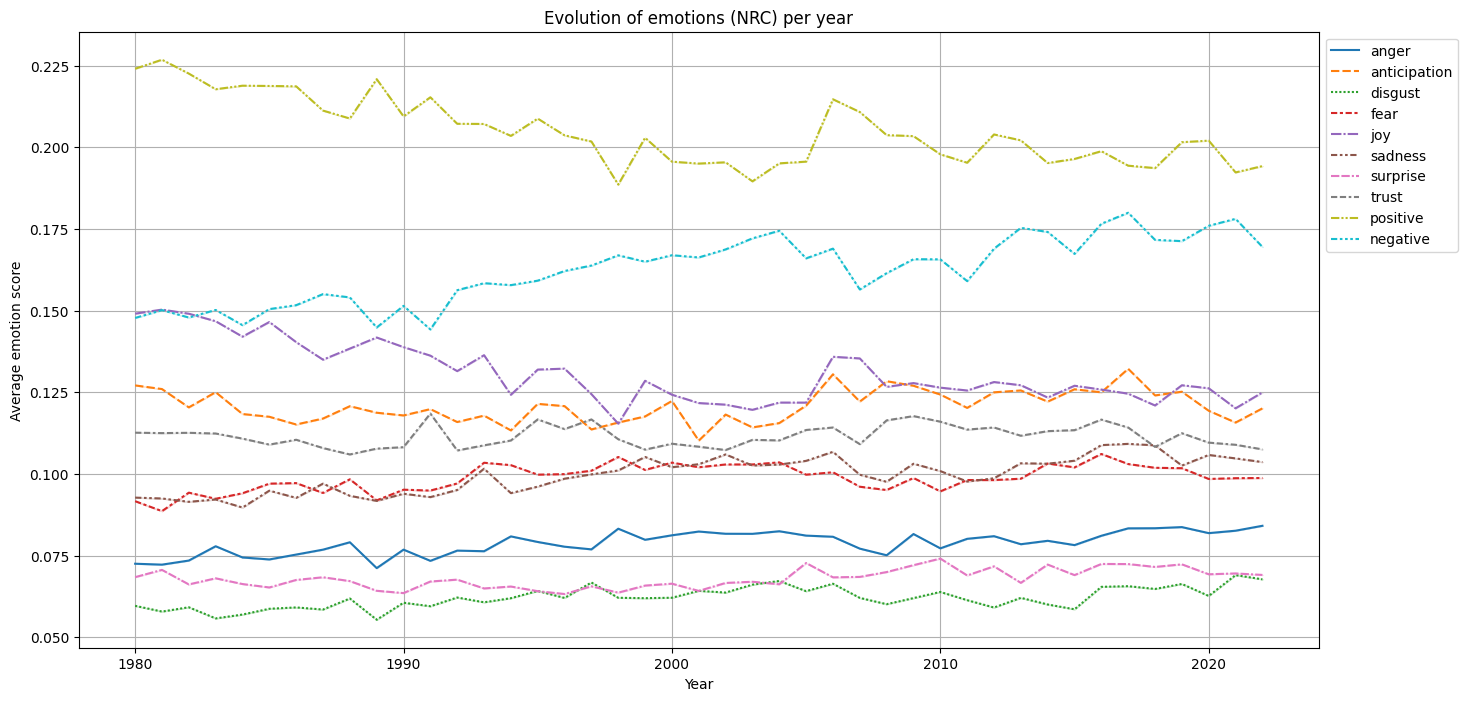

In [16]:
# Mean per year - flop songs
emotion_year = df_flop.groupby("year")[
    ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]
].mean()

plt.figure(figsize=(16,8))
sns.lineplot(data=emotion_year)
plt.title("Evolution of emotions (NRC) per year")
plt.xlabel("Year")
plt.ylabel("Average emotion score")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

## LDA

In [3]:
# Concatenation df_top et df_flop
df = pd.concat([df_top, df_flop], ignore_index=True)

In [4]:
# Configuration du CountVectorizer
cv = CountVectorizer(
    max_df=0.9,           # Ignore les mots dans >90% des documents
    min_df=2,             # Ignore les mots apparaissant <2 fois
    stop_words='english'  # Retire les stop words anglais
)

print("CountVectorizer configuré")
print(f"  - max_df: {cv.max_df} (mots trop fréquents exclus)")
print(f"  - min_df: {cv.min_df} (mots trop rares exclus)")
print(f"  - stop_words: {len(cv.get_stop_words())} mots exclus")

CountVectorizer configuré
  - max_df: 0.9 (mots trop fréquents exclus)
  - min_df: 2 (mots trop rares exclus)
  - stop_words: 318 mots exclus


In [6]:
# Construction of Document-Term martrix 
dtm = cv.fit_transform(df['clean_lyrics'])

print(f"Matrice Document-Terme créée")
print(f"  - Forme: {dtm.shape} (documents x vocabulaire)")
print(f"  - {dtm.shape[0]} documents")
print(f"  - {dtm.shape[1]} mots dans le vocabulaire")
print(f"  - Type: {type(dtm)} (matrice sparse pour économie mémoire)")

Matrice Document-Terme créée
  - Forme: (86000, 49877) (documents x vocabulaire)
  - 86000 documents
  - 49877 mots dans le vocabulaire
  - Type: <class 'scipy.sparse._csr.csr_matrix'> (matrice sparse pour économie mémoire)


In [30]:
# Initialisation du modèle LDA
LDA = LatentDirichletAllocation(
    n_components=15,      # Nombre de topics à découvrir
    random_state=42      # Pour reproductibilité
)

print("Modèle LDA initialisé avec 15 topics")

Modèle LDA initialisé avec 15 topics


In [31]:
# Approximately 8 minutes to run
# Entraînement du modèle
# Cela peut prendre du temps avec beaucoup de documents
print("Entraînement du modèle LDA top...")
LDA_top = LDA.fit(dtm_top)
print("✓ Entraînement terminé !")

Entraînement du modèle LDA top...
✓ Entraînement terminé !


In [ ]:
# Extraction du premier topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution sur {len(single_topic)} mots")

Topic 0 - Distribution sur 38136 mots


In [38]:
top_ten_words = single_topic.argsort()[-10:]

In [39]:
# Conversion des indices en mots
print("\nTop 10 mots du Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probabilité: {prob:.4f})")


Top 10 mots du Topic 0:


IndexError: index 37106 is out of bounds for axis 0 with size 33087

In [35]:
# Boucle sur tous les topics
print("=" * 70)
print("TOPICS DÉCOUVERTS PAR LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-15:]]
    print("Top 15 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 15 mots: said, way, head, summer, man, whoa, blue, red, white, let, black, old, time, like, ooh

TOPIC #1
----------------------------------------------------------------------
Top 15 mots: mind, mary, joy, loves, singing, wild, hear, bum, need, yes, sing, christmas, boy, song, doo

TOPIC #2
----------------------------------------------------------------------
Top 15 mots: end, days, face, remember, time, think, lonely, falling, right, hard, look, eyes, life, fall, night

TOPIC #3
----------------------------------------------------------------------
Top 15 mots: better, mother, going, boom, wait, good, bang, said, think, know, like, got, bit, life, little

TOPIC #4
----------------------------------------------------------------------
Top 15 mots: hallelujah, earth, dey, come, let, praise, glory, power, heaven, king, holy, sing, jesus, lord, god

TOPIC #5
-------------------

### Flop songs

In [40]:
# CountVectorizer configuration
cv = CountVectorizer(
    max_df=0.9,           
    min_df=2,             
    stop_words='english'  
)

# Construction of Document-Term martrix - flop songs
dtm_flop = cv.fit_transform(df_flop['clean_lyrics'])

print(f"Matrice Document-Terme créée")
print(f"  - Forme: {dtm_flop.shape} (documents x vocabulaire)")
print(f"  - {dtm_flop.shape[0]} documents")
print(f"  - {dtm_flop.shape[1]} mots dans le vocabulaire")
print(f"  - Type: {type(dtm_flop)} (matrice sparse pour économie mémoire)")

Matrice Document-Terme créée
  - Forme: (43000, 33087) (documents x vocabulaire)
  - 43000 documents
  - 33087 mots dans le vocabulaire
  - Type: <class 'scipy.sparse._csr.csr_matrix'> (matrice sparse pour économie mémoire)


In [42]:
# Approximately 8 minutes to run
print("Entraînement du modèle LDA flop...")
LDA_flop = LDA.fit(dtm_flop)
print("✓ Entraînement terminé !")

Entraînement du modèle LDA flop...
✓ Entraînement terminé !


In [43]:
# Extraction du premier topic
single_topic = LDA.components_[0]
print(f"Topic 0 - Distribution sur {len(single_topic)} mots")
top_ten_words = single_topic.argsort()[-10:]

# Conversion des indices en mots
print("\nTop 10 mots du Topic 0:")
for index in top_ten_words:
    word = cv.get_feature_names_out()[index]
    prob = single_topic[index]
    print(f"  - {word:<20} (probabilité: {prob:.4f})")

Topic 0 - Distribution sur 33087 mots

Top 10 mots du Topic 0:
  - bring                (probabilité: 1713.4139)
  - shine                (probabilité: 1733.6478)
  - day                  (probabilité: 1781.9022)
  - sun                  (probabilité: 1783.6234)
  - dream                (probabilité: 2220.2606)
  - let                  (probabilité: 2458.1316)
  - tonight              (probabilité: 3476.1414)
  - light                (probabilité: 3723.0206)
  - night                (probabilité: 6447.7353)
  - ooh                  (probabilité: 8992.4080)


In [44]:
# Boucle sur tous les topics
print("=" * 70)
print("TOPICS DÉCOUVERTS PAR LDA")
print("=" * 70)

for i, topic in enumerate(LDA.components_):
    print(f"\nTOPIC #{i}")
    print("-" * 70)
    top_words = [cv.get_feature_names_out()[idx] for idx in topic.argsort()[-15:]]
    print("Top 15 mots:", ', '.join(top_words))

print("\n" + "=" * 70)

TOPICS DÉCOUVERTS PAR LDA

TOPIC #0
----------------------------------------------------------------------
Top 15 mots: good, moon, come, summer, party, bring, shine, day, sun, dream, let, tonight, light, night, ooh

TOPIC #1
----------------------------------------------------------------------
Top 15 mots: father, stand, praise, joy, power, glory, come, holy, king, let, sing, heaven, jesus, god, lord

TOPIC #2
----------------------------------------------------------------------
Top 15 mots: home, eyes, sky, night, cold, dark, river, water, death, land, sun, black, wind, sea, blood

TOPIC #3
----------------------------------------------------------------------
Top 15 mots: girls, say, girl, old, think, boy, little, said, money, big, know, man, good, got, like

TOPIC #4
----------------------------------------------------------------------
Top 15 mots: rock, home, cause, make, like, feel, gotta, yeah, way, know, hey, want, got, baby, wanna

TOPIC #5
---------------------------------

# Test - OLS Regression

In [37]:
import pandas as pd
import statsmodels.api as sm

major_crisis_years = {
    1992: "Émeutes de Los Angeles (Rodney King)",
    2001: "Attentats du 11 septembre",
    2008: "Crise financière mondiale",
    2016: "Brexit / Élection Trump",
    2020: "COVID-19 / George Floyd (BLM mondial)",
    2022: "Guerre en Ukraine / inflation mondiale"
}

crisis_years = set(us_event_years.keys())

def prepare_reg_df_lag(df, crisis_years):
    # Moyenne du sentiment par année
    df_year = df.groupby("year")["sentiment"].mean().reset_index()
    
    # La variable 'crisis' = 1 si l'année est l'année **après** une crise majeure
    df_year["crisis"] = df_year["year"].isin([y + 1 for y in crisis_years]).astype(int)
    
    return df_year

# Crises majeures négatives
major_crisis_years = {1992, 2001, 2003, 2005, 2008, 2013, 2014, 2016, 2020, 2021, 2022}

reg_top = prepare_reg_df_lag(df_top, major_crisis_years)
reg_flop = prepare_reg_df_lag(df_flop, major_crisis_years)

In [38]:
def run_ols_trend(df):
    X = df[["crisis", "year"
            ]]
    X = sm.add_constant(X)
    y = df["sentiment"]
    model = sm.OLS(y, X).fit(cov_type="HC3")
    return model

model_top_trend = run_ols_trend(reg_top)
model_flop_trend = run_ols_trend(reg_flop)

print(model_top_trend.summary())
print(model_flop_trend.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.1181
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.889
Time:                        11:12:36   Log-Likelihood:                 78.913
No. Observations:                  43   AIC:                            -151.8
Df Residuals:                      40   BIC:                            -146.5
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3586      1.204      0.298      0.7

In [40]:
def prepare_reg_df_2020(df):
    # Moyenne du sentiment par année
    df_year = df.groupby("year")["sentiment"].mean().reset_index()
    
    # crise = 1 uniquement pour 2020 (ou 2021 si tu veux l'année après)
    df_year["crisis"] = (df_year["year"] == 2021).astype(int)
    
    return df_year

reg_top_2020 = prepare_reg_df_2020(df_top)
reg_flop_2020 = prepare_reg_df_2020(df_flop)

import statsmodels.api as sm

def run_ols(df):
    X = sm.add_constant(df["crisis"])
    y = df["sentiment"]
    model = sm.OLS(y, X).fit(cov_type="HC3")  # robust SE
    return model

print("=== TOP SONGS (2020) ===")
print(run_ols(reg_top_2020).summary())

print("\n=== FLOP SONGS (2020) ===")
print(run_ols(reg_flop_2020).summary())


=== TOP SONGS (2020) ===
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                 0.0003814
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.985
Time:                        11:14:50   Log-Likelihood:                 78.737
No. Observations:                  43   AIC:                            -153.5
Df Residuals:                      41   BIC:                            -150.0
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4781      

# Flesch kincaid

In [3]:
df_top["group"] = "top"
df_flop["group"] = "flop"

df_all = pd.concat([df_top, df_flop], ignore_index=True)

In [ ]:
import textstat
def compute_flesch_scores(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return pd.Series([None, None])
    
    return pd.Series([
        textstat.flesch_reading_ease(text),
        textstat.flesch_kincaid_grade(text)
    ])

df_all[["flesch_reading_ease", "flesch_kincaid_grade"]] = (
    df_all["clean_lyrics"]
    .apply(compute_flesch_scores)
)

In [9]:
df_all.groupby("group")[[
    "flesch_reading_ease",
    "flesch_kincaid_grade"
]].describe()

flesch_reading_ease                                                \
                    count       mean        std          min        25%   
group                                                                     
flop              42999.0 -11.491949  56.128863 -1394.509910 -37.126400   
top               43000.0 -46.854022  82.760098 -3938.447378 -77.992561   

                                     flesch_kincaid_grade             \
             50%        75%      max                count       mean   
group                                                                  
flop   -3.021724  25.147465  120.205              42999.0  37.993650   
top   -32.777894   2.656316  117.160              43000.0  52.115452   

                                                                      
             std   min        25%        50%        75%          max  
group                                                                 
flop   21.103993 -3.01  24.020000  34.345385  47.300826   565.750035  
top    31.574962 -1.84  33.144051  46.395652  63.828535  1540.405793

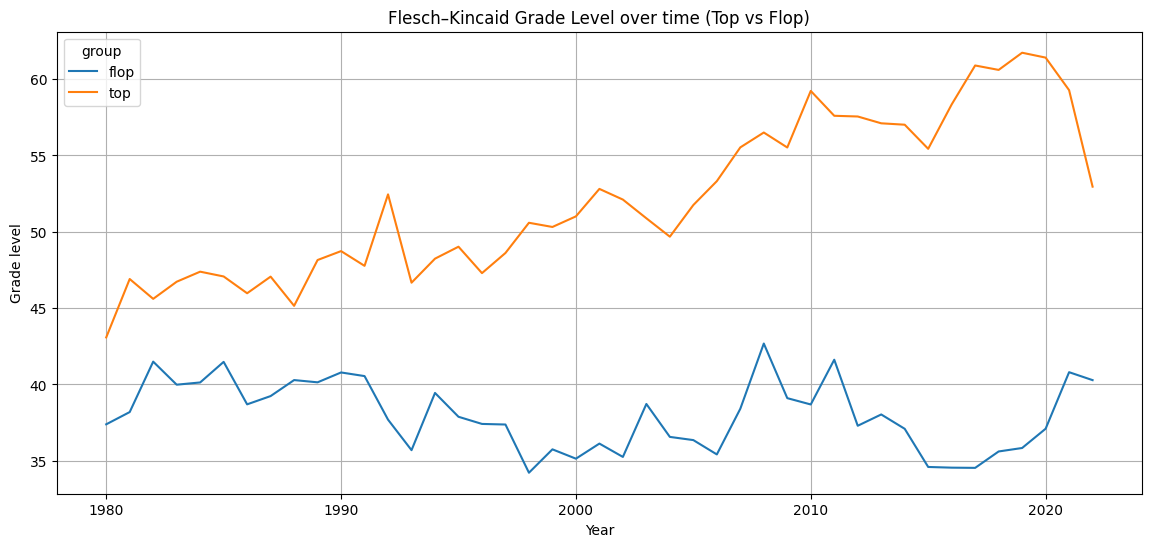

In [ ]:
fk_by_year = (
    df_all
    .groupby(["year", "group"])["flesch_kincaid_grade"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=fk_by_year, x="year", y="flesch_kincaid_grade", hue="group")
plt.title("Flesch-Kincaid Grade Level over time (Top vs Flop)")
plt.ylabel("Grade level")
plt.xlabel("Year")
plt.grid(True)
plt.show()
